# Create all charts
---

## The data sets we used are:
* City of Austin, austin_311_service_requests.csv
* The Travis county zip codes from the US Census Bureau.
* Social/Economic census data for Austin, TX by zipcode from the US Census Bureau
* City of Austin Household statistics from the US Census Bureau.

In [1]:
import os
import datetime
import numpy as np
import regex as reg
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
path_311 = os.path.join('..', 'data', '311_cleaned_data_.csv')
df = pd.read_csv(path_311)
df.dropna(inplace=True)
df.count()

service_request_id      29578
status_description      29578
mobile_web_status       29578
duplicate_verified      29578
override_duplicate      29578
functional_location     29578
source                  29578
closed_date             29578
updated_datetime        29578
open                    29578
closed                  29578
description             29578
agency_responsible      29578
service_name            29578
service_subtype         29578
lat                     29578
long                    29578
sap_problem_category    29578
sap_problem_type        29578
address                 29578
case_record_type        29578
district                29578
date                    29578
time                    29578
weekday                 29578
year                    29578
month                   29578
day                     29578
dtype: int64

### Number of 311 calls by month

* calls from 2017-03-11 to 2018-03-10

In [3]:
print('min:', df['date'].min())
print('max:', df['date'].max())

min: 2016-05-20
max: 2018-03-10


In [22]:
period_311 = df[df['date'] > '2017-03-10']
period_311 = period_311[period_311['date'] < '2018-03-11']
months = period_311.groupby('month', as_index=False)['service_request_id'].count()
months['month'] = months['month'].map(lambda x: datetime.date(1900, int(x), 1).strftime('%B'))

In [23]:
period_311.head()

,service_request_id,status_description,mobile_web_status,duplicate_verified,override_duplicate,functional_location,source,closed_date,updated_datetime,open,...,sap_problem_type,address,case_record_type,district,date,time,weekday,year,month,day
61877,305193,Closed,Closed,0,0,q,Mobile,2018-03-11T03:15:00,2018-03-11T03:15:00,0,...,ReReferral,"1000-1032 Sea World Dr, San Diego, CA 92110, USA",Street Division Closed Case,2.00,2018-03-10,18:18:00,Saturday,2018,3,10
61910,305112,Closed,Closed,0,0,SS-031091,Phone,2018-04-13T08:02:00,2018-07-10T10:24:00,0,...,Debris in Street,"13500 CAM DEL SUR, 92129",Storm Water Closed Case,5.00,2018-03-09,16:34:00,Friday,2018,3,9
61911,305111,Closed,Closed,0,0,SS-019733,Email,2018-04-10T09:16:00,2018-04-10T09:16:00,0,...,Debris in Street,6000 NAVAJO RD,Storm Water Closed Case,7.00,2018-03-09,16:30:00,Friday,2018,3,9
61937,305084,Closed,Closed,0,0,SS-015691,Phone,2018-04-02T08:36:00,2018-04-26T09:25:00,0,...,Bike Removal,"1501 LA PLAYA AV, 92109",Street Division Closed Case,2.00,2018-03-09,14:52:00,Friday,2018,3,9
61951,305070,Closed,Closed,0,0,SS-020446-PV1,Phone,2018-07-26T02:28:00,2018-07-26T02:28:00,0,...,Debris in Street,"ROSECRANS ST & OLIPHANT ST,, 92106",Storm Water,2.00,2018-03-09,14:27:00,Friday,2018,3,9


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

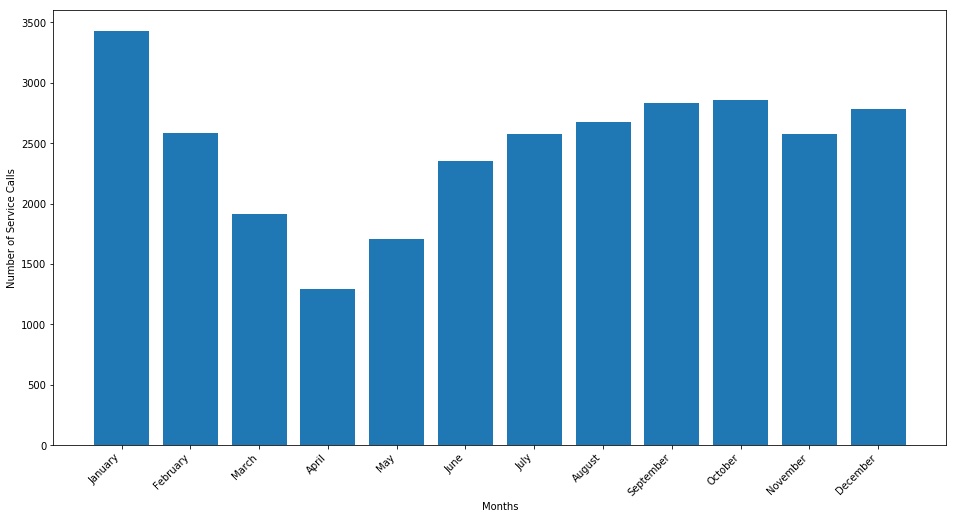

In [6]:
plt.figure(figsize=[16, 8])
plt.bar(months['month'], months['service_request_id'])
plt.xlabel('Months')
plt.ylabel('Number of Service Calls')
plt.xticks(rotation=45, ha='right')

### Number of 311 calls by type

* Garrett is working on this

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

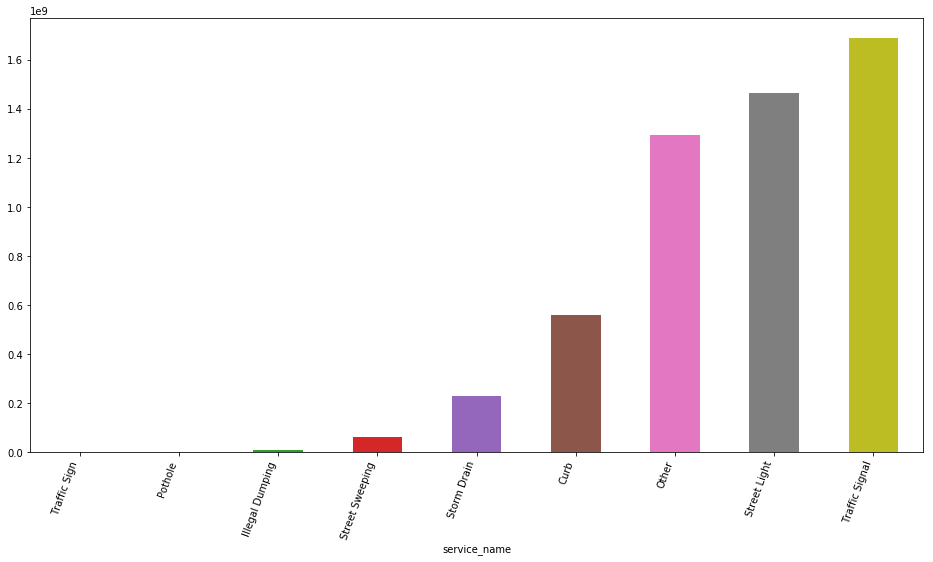

In [7]:
service_df = df.groupby('service_name')
service = service_df['service_request_id'].sum().sort_values()
fig, ax = plt.subplots(figsize=[16, 8])
service.plot.bar()
plt.xticks(rotation=70, ha='right')

### breakdown of percentage of call categories

In [8]:
df['case_record_type'].unique()

array(['Street Division Closed Case', 'Storm Water Closed Case',
       'Storm Water', 'Traffic Engineering',
       'Traffic Engineering Closed Case', 'Street Division'], dtype=object)

### locations of callers (bubble plot?)

### Number of calls per capita by zipcode

In [9]:
pop_path = os.path.join('..', 'data', 'census_population_by_zip.csv')
pop_df = pd.read_csv(pop_path)
pop_df.head()

,zip_code,total population
0,91901,18586
1,91902,19429
2,91905,1539
3,91906,3565
4,91910,76027


### Number of calls by median household income of zip

In [10]:
income_path = os.path.join('..', 'data', 'census_income_by_zip.csv')
income_df = pd.read_csv(income_path)
income_df.head()

,zip_code,Mean income,MoE Mean income,Median income,MoE Median income
0,91911,62932,2137,51383,1874
1,91914,137640,8680,124578,7047
2,91915,111918,8589,104170,6753
3,91932,59870,2942,48010,1975
4,91942,70677,3837,55753,3194


### Number of calls by crime rate of zip

### Percent of call types by median household income (stacked bar)

### Number of calls by Temperature scatter

* calls from 2017-03-11 to 2018-03-10

In [42]:
owm_path = os.path.join('..', 'data', 'owm_2016_2018.csv')
temp_df = pd.read_csv(owm_path)
temp_df['date'] = temp_df['dt_iso'].map(lambda x: reg.sub('\s\d{2}:\d{2}:\d{2}\s\+\d{4}\sUTC', '', x))
temp_df = temp_df[temp_df['date'] > '2017-03-10']
temp_df = temp_df[temp_df['date'] < '2018-03-11']
temp_df = temp_df.groupby('date', as_index=False).mean()
temp_df.head()

,date,temp_f,pressure,humidity
0,2017-03-11,61.41,"1,016.40",59.76
1,2017-03-12,58.10,"1,016.19",83.98
2,2017-03-13,58.62,"1,016.76",85.24
3,2017-03-14,61.57,"1,017.22",78.06
4,2017-03-15,65.25,"1,018.46",69.46


In [43]:
date_311 = period_311.groupby('date', as_index=False).count()
date_311.head()

,date,service_request_id,status_description,mobile_web_status,duplicate_verified,override_duplicate,functional_location,source,closed_date,updated_datetime,...,sap_problem_category,sap_problem_type,address,case_record_type,district,time,weekday,year,month,day
0,2017-03-11,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
1,2017-03-12,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
2,2017-03-13,75,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75
3,2017-03-14,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
4,2017-03-15,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61


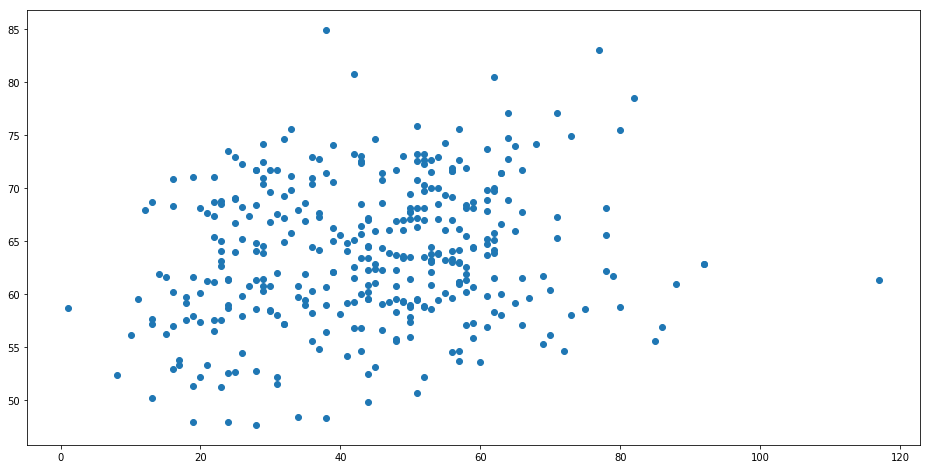

In [34]:
plt.figure(figsize=[16, 8])
plt.scatter(date_311['service_request_id'], temp_df['temp_f'])

### Number fo calls by weekday

In [44]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', ]
weekdays = df.groupby('weekday', as_index=False)['service_request_id'].count()
weekdays['day_order'] = weekdays['weekday'].map(lambda x: days.index(x))
weekdays.sort_values('day_order', inplace=True)
weekdays

,weekday,service_request_id,day_order
1,Monday,4871,0
5,Tuesday,5140,1
6,Wednesday,5070,2
4,Thursday,4801,3
0,Friday,4631,4
2,Saturday,2688,5
3,Sunday,2377,6


<BarContainer object of 7 artists>

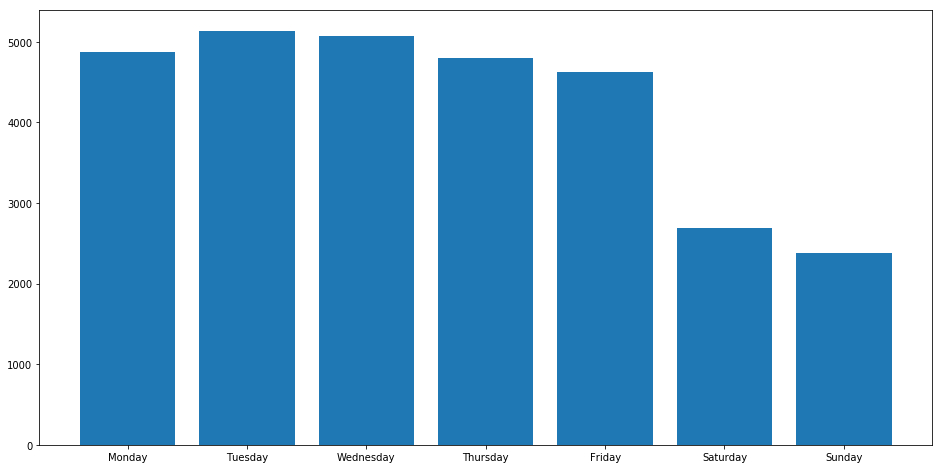

In [45]:
plt.figure(figsize=[16, 8])
plt.bar(weekdays['weekday'], weekdays['service_request_id'])